In this post I will create a [Buddhabrot](https://en.wikipedia.org/wiki/Buddhabrot) fractal with pyopencl. Before I start I should say that this is my first attempt at a Buddhabrot and one of my first openCL programs, so I make no claims that this is the best way to make a Buddabrot with openCL. In fact I will argue below that the technique is fairly inefficient and I hope to explore soome ways to improve it in later posts.

## Mandelbrot in openCL
The Buddhabrot is essentially another way of looking at the Mandelbrot set (or more accurately, the complement of the Mandelbrot set). The Mandelbrot set is the set of complex numbers $z$ for which the sequence defined by the recurrence relation:

$$
\begin{align}
z_{n+1} &= z_n^2 + z\\
z_0 &= z
\end{align}
$$

is bounded. The set forms a beautiful fractal in the complex plane. The points outside the set all diverge to complex infinity, but points near the border have very complicated and interesting trajectories before they converge. These complicated, but utlimately divergent, trajectories are what the Buddhabrot helps us visualize. But first, lets try plotting the mandelbrot set using pyopencl and matlotlib. See my [previous post]() about pyopencl if you haven't worked with it before.

We'll start with the imports we will need.

In [27]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import matplotlib.pyplot as plt

Next I will use the matplotlib magic and the pyopencl magic so that I can use both in my interactive jupyter session (I do almost everything in [jupyter](http://jupyter.org/)!).

In [3]:
%matplotlib inline

In [5]:
%load_ext pyopencl.ipython_ext

Next we will need an opencl context (in this case it will just be the GPU of my Apple notebook) adn a comand queue for the context.

In [28]:
ctx = cl.create_some_context(interactive=True)

In [29]:
queue = cl.CommandQueue(ctx)

To plot the mandelbrot set, we will take a large sample of points from the complex plane, then we will apply the above recurrence relation many times and see which points have divergent sequences. "How can we do this in finite time?" you ask, well luckily there is a nice theorem that tells us that if $\rvert z_n \rvert >4$ for some $n$ in the above sequence, then the sequence diverges. So we just need to iterate until the absolute value becomes greater than 4 or until some specified number of iterations has been reached.

The code for this would look something like this:

```C
for(i=0; i<max_iter; i++) {
    z_i = z_i * z_i + z;
    if(abs(z_i)>4.) break;
}
```
except that we need complex datatypes for `z_i` and `z`. Luckily pyopencl has [support](https://documen.tician.de/pyopencl/array.html#complex-numbers) for this. We just need to import `pyopencl-complex.h` before defining our kernel and we will have a new type `cfloat_t` along with basic functions like `cfloat_add` and `c_float_mul`. This makes the main part of the mandelbrot code look like this:

```C
for(i=0; i<max_iter; i++) {
    z_i = cfloat_add(cfloat_mul(z_i,z_i),z);
    if(cfloat_abs(z_i)>4.) break;
}
```

We will run this loop in parallel for all of the complex numbers in our sample. If the loop breaks before reaching `max_iter` iterations, we know that `z` is not in the Mandelbrot set, so what we really want is to record `i` for each complex number we are interested in. Which complex numbers are we interested in? Well, we want to end up with an image, i.e. a rectangular array of pixels, where each pixel corresponds to a point on the complex plane. So we need a mapping from the pixels in our image to points on the complex plane. We do this as follows:

```C
float re = re_min + ((re_max - re_min)/w)*x_i;
float im = im_min + ((im_max - im_min)/h)*y_i;
```

where `re_min/max` and `im_min/max` set the bounds of our rectangle in the complex plane and `w` and `h` are the width and height of the desired image in pixels. There are a few ways we could pass these variables to the kernel, but one way that seems to work nicely is to create a [custom data type](https://documen.tician.de/pyopencl/array.html#custom-data-types) that contains all of the parameters. We define the type in python with numpy and also in C with `typedef` and then we use pyopencl's helper functions to match them up. Let's put all of this together:

In [8]:
# Define our custom data type in numpy
params = np.dtype([
    ('h_px',np.int32),
    ('w_px',np.int32),
    ('re_min',np.float32),
    ('re_max',np.float32),
    ('im_min',np.float32),
    ('im_max',np.float32),
    ('max_iter',np.int32)
])

In [9]:
# Tell pyopencl to associate our new 'params' datatype with a datatype in C that we will define below.
params, params_c_decl = cl.tools.match_dtype_to_c_struct(ctx.devices[0], "params", params)
params = cl.tools.get_or_register_dtype("params", params)

In [30]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-complex.h>

//Here is our C definition of params
typedef struct {
  int h_px;
  int w_px;
  float re_min;
  float re_max;
  float im_min;
  float im_max;
  int max_iter;
} params;

__kernel void mandelbrot(
    __global int *result,
    __global params *my_params
)
{
    int h = (*my_params).h_px;
    int w = (*my_params).w_px;
    float re_min = (*my_params).re_min;
    float re_max = (*my_params).re_max;
    float im_min = (*my_params).im_min;
    float im_max = (*my_params).im_max;
    int max_iter = (*my_params).max_iter;
    
    // Assign a pixel (x_i,y_i) to each thread
    int gid = get_global_id(0);
    int x_i = gid % w;
    int y_i = gid / w;
    
    // Convert pixel coordinates to complex plane coordinates
    float re = re_min + ((re_max - re_min)/w)*x_i;
    float im = im_min + ((im_max - im_min)/h)*y_i;
    cfloat_t z = cfloat_new(re,im);
    cfloat_t z_i = z;
    
    // Mandelbrot 
    int i;
    for(i=0; i<max_iter; i++) {
        z_i = cfloat_add(cfloat_mul(z_i,z_i),z);
        if(cfloat_abs(z_i)>4.) break;
    }
    result[gid] = i;
}

Before we run the kernel, we need to create the inputs and pass them to the GPU.

In [58]:
h_px = 400
w_px = 600
re_min = -2.
re_max = 1.
im_min = -1
im_max = 1
max_iter = 1000

p = (h_px,w_px,re_min,re_max,im_min,im_max,max_iter)
my_params_host = np.array([p],dtype=params)
my_params_host

array([(400, 600, -2.,  1., -1.,  1., 1000)],
      dtype=[('h_px', '<i4'), ('w_px', '<i4'), ('re_min', '<f4'), ('re_max', '<f4'), ('im_min', '<f4'), ('im_max', '<f4'), ('max_iter', '<i4')])

`my_params_host` is just a on-element numpy array (with our custom data type) sitting in memory on the host device. We can move it to the GPU as follows:

In [59]:
my_params = cl.array.to_device(queue,my_params_host)

We also need to instantiate the `results` array. We need it to have one element for each pixel.

In [60]:
n = w_px*h_px
result = cl.array.empty(queue, n, dtype=np.int32)

Now we are ready to queue the kernel and run it.

In [61]:
mandelbrot(queue, (n,), None, result.data,my_params.data)

In [62]:
result_host = result.get()

Now let's visualize the results.

In [63]:
mandel_img = result_host.reshape([h_px,w_px])

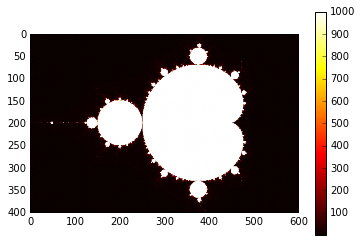

In [64]:
plt.imshow(mandel_img, cmap='hot', interpolation='gaussian')
plt.colorbar()

Most of the sequences that started outside the Mandelbrot set diverged fairly quickly, that is why we see mostly black with just a hing of orange near the border. To get a more interesting plot we can just take the log:

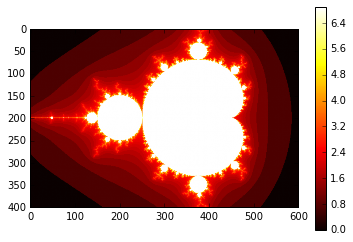

In [65]:
plt.imshow(np.log(mandel_img), cmap='hot', interpolation='gaussian')
plt.colorbar()

## Back to the Buddhabrot

Drawing the Mandelbrot set is probably a task better suited to openGL ([check out my Mandelbrot/Julia fragment shader on shadertoy](https://www.shadertoy.com/view/4tBcWy)). The Buddhabrot, on the other hand, is tricky to implement in OpenGL because it is not straightforward to compute the value of each pixel independently. So what is the Buddhabrot exactly? The Buddhabrot is a 2d histogram on the complex plane which counts the number of times that any of the sequences that start outside the Mandelbrot set pass through a point in the given bucket. In other words, we a rectangle in the complex plane, split it into 'buckets', i.e. small regularly spaced rectangles that cover the main rectangle, then we do the same Mandelbrot iteration above on a set of complex numbers and each time the iteration produces a value in one of the buckets, we increment the count of that bucket. Then we can plot the histogram as a heatmap, i.e. a 2d image whose pixels correspond to buckets in the histogram and whose color corresponds to the value of the histogram at the given bucket.

For our OpenCL kernel, we will use an array called `visits` to store the number of times a non-mandelbrot sequence has visited each bucket. We will use the same parameters as before to associate a set of pixels with a rectangular region of the complex plane. Further, we will use these pixels as our buckets. 

To get the non-Mandelbrot points, we will go through the standard Mandelbrot program as given above and then select only those points whose sequences escaped before the maximum iterations (i.e. where ```i < max_iter``` ). Then, for only these points, we will start the Mandelbrot iteration process again from the beginning and increment our bucket counts at each step.

We already saw how to map from pixels to points in the complex plane in the Mandelbrot example, to map each point back to the corresponing pixel/bucket we just implement the inverse transformation:

```C
int bucket_x = int((z.real - re_min) * w / (re_max - re_min));
int bucket_y = int((z.imag - im_min) * h / (im_max - im_min));
```

The bucket counts will be stored in an array called `visits` where `visits[bucket_y * w + bucket_x]` will give the number of times the bucket at `(bucket_x,bucket_y)` was visited.

Let's see what all of this looks like put together:

In [66]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-complex.h>

typedef struct {
  int h_px;
  int w_px;
  float re_min;
  float re_max;
  float im_min;
  float im_max;
  int max_iter;
} params;

__kernel void buddhabrot(
    __global int *visits,
    __global params *my_params
)
{
    int h = (*my_params).h_px;
    int w = (*my_params).w_px;
    float re_min = (*my_params).re_min;
    float re_max = (*my_params).re_max;
    float im_min = (*my_params).im_min;
    float im_max = (*my_params).im_max;
    int max_iter = (*my_params).max_iter;
    
    int gid = get_global_id(0);
    int n = get_global_size(0);
    int x_i = gid % w;
    int y_i = gid / w;
    float re = re_min + ((re_max - re_min)/w)*x_i;
    float im = im_min + ((im_max - im_min)/h)*y_i;
    cfloat_t z = cfloat_new(re,im);
    cfloat_t c = z;
    int i;
    for(i=0; i<max_iter; i++) {
        z = cfloat_add(cfloat_mul(z,z),c);
        if(cfloat_abs(z)>4.) break;
    }
    
    z = c;
    if(i < max_iter) {
        for(i=0; i<max_iter;i++) {
            z = cfloat_add(cfloat_mul(z,z),c);
            if(cfloat_abs(z)>4.) break;
            int bucket_x = int((z.real - re_min) * w / (re_max - re_min));
            int bucket_y = int((z.imag - im_min) * h / (im_max - im_min));
            int idx = bucket_y * w + bucket_x;
            if(idx>=0 && idx<n){
                visits[bucket_y * w + bucket_x]++;
            }
        }
    }
}

Next, we run through the same steps as for the Mandelbrot torun the kernel and turn the result into an image. I will use a higher resolution this time so that we can see more details of the structure.

In [67]:
h_px = 800
w_px = 1200
x_min = -2.
x_max = 1.
y_min = -1
y_max = 1
max_iter = 1000

p = (h_px,w_px,x_min,x_max,y_min,y_max,max_iter)
my_params_host = np.array([p],dtype=params)
my_params = cl.array.to_device(queue,my_params_host)

n = w_px*h_px

visits = cl.array.empty(queue, n, dtype=np.int32)

In [68]:
buddhabrot(queue, (n,), None, visits.data,my_params.data)

In [69]:
result = visits.get()

In [70]:
buddha_img=np.reshape(result,[h_px,w_px])

It is customary to rotate the Buddhabrot 90 degrees so that the shape looks like Buddha sitting and meditating. We can easily achieve the same effect by taking the transpose of the image matrix.

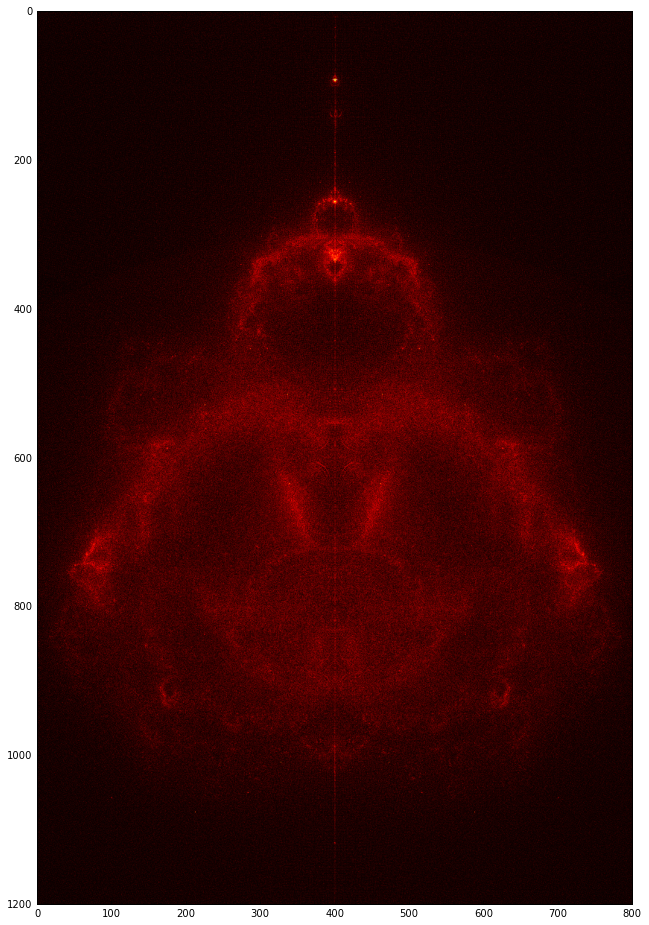

In [71]:
plt.figure(figsize = (24,16))
plt.imshow(buddha_img.T, cmap='hot', interpolation='gaussian')

The image is nice and you can definitely see the Buddha shape, but it is still a little fuzzy and grainy. Let's try increasing the number of iterations to 100000.

In [72]:
h_px = 800
w_px = 1200
x_min = -2.
x_max = 1.
y_min = -1
y_max = 1
max_iter = 100000

p = (h_px,w_px,x_min,x_max,y_min,y_max,max_iter)
my_params_host = np.array([p],dtype=params)
my_params = cl.array.to_device(queue,my_params_host)

n = w_px*h_px

visits = cl.array.empty(queue, n, dtype=np.int32)

In [73]:
buddhabrot(queue, (n,), None, visits.data,my_params.data)

In [74]:
result = visits.get()

In [75]:
buddha_img=np.reshape(result,[h_px,w_px])

Note I have added the argument `vmax=np.percentile(img,99.9)`. Without this there is too much difference between the high and low values and most of the image is almost black.

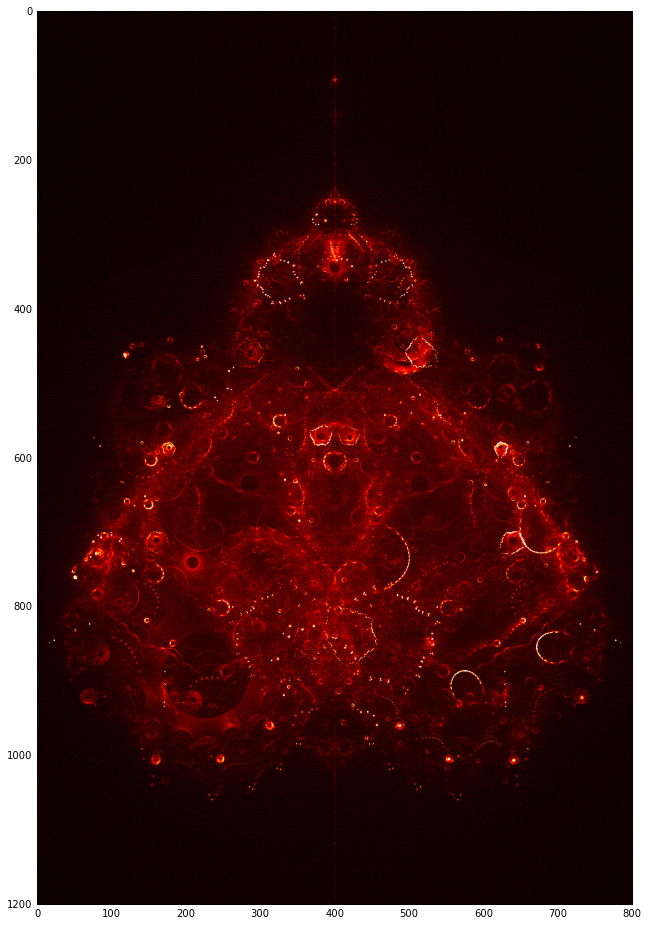

In [76]:
plt.figure(figsize = (24,16))
plt.imshow(buddha_img.T, cmap='hot', interpolation='gaussian',vmax=np.percentile(img,99.9))

Now we can start to see some really intricate and beautiful details start to emerge. As with the standard mandelbrot it is somewhat mind-boggling how much complexity there is give how mathematically simple the definition is.

## Future improvements

As I said earlier, this kernel is not really taking full advantage of the power of parallelism. To see why, let's revisit the Mandelbrot picture from earlier.

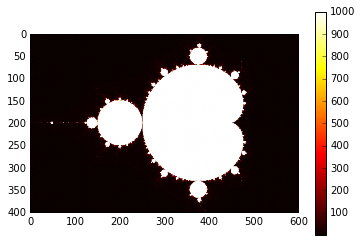

In [77]:
plt.imshow(mandel_img, cmap='hot', interpolation='gaussian')
plt.colorbar()

We will have a worker for each pixel in this image, but after the initial Mandelbrot process, all of the workers whose points fall in to the white part of the above image (i.e. the points which are more likely to be in the Mandelbrot set) will not be used for generating the Buddhabrot. Furthermore, if we look more closely at the distribution of the remaining points:

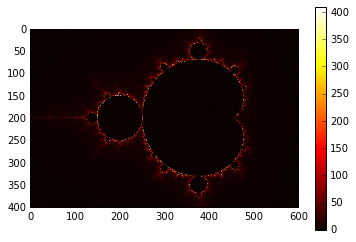

In [82]:
non_mandel_img = np.where(mandel_img<1000,mandel_img,0)
plt.imshow(non_mandel_img, cmap='hot', interpolation='gaussian',vmax=np.percentile(non_mandel_img,99.9))
plt.colorbar()

We can that only a tiny fraction of the non-Mandelbrot points have sequences that will last more than 100 iterations before escaping, to say nothing of 100000 iterations. This means that all of these fine details that we gain from moving from 1000 iterations to 100000 iterations come from a subset of points event thinner than the bright part of the above image. In other words, during the Buddhabrot process, the vast majority of the workers have stopped working long before the 100000 iterations are finished. Most of the time during the execution of this kernel, only a few workers will be actively computing.

To overcome this problem, in a future post I plan to resample after the initial Mandelbrot process in such a way that most of the points are near the border of the manderbrot set. I got this idea from [Benedikt Bitterli's blog](https://benedikt-bitterli.me/buddhabrot/).

Thanks for reading!